In [1]:
%load_ext autoreload
%autoreload 2

# Membrane Current Models

This notebook contains membrane current experiments, mainly considered as ODE's over a cell membrane. The main purpose is to gain insight into how these models work, what is required to trigger an action potential and how they renormalize.

Implementation will be done using `scipy`

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

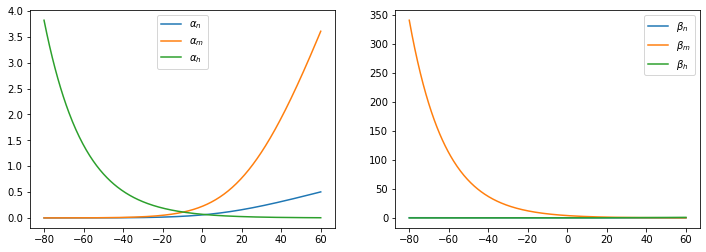

In [3]:
alpha_n = lambda u: 0.01 * (10. - u) / (np.exp((1. - 0.1*u)) - 1.)
alpha_h = lambda u: 0.07 * np.exp(- u / 20.)
def alpha_m(u):
    arr = np.zeros_like(u)
    mask = (np.abs(u - 25.) > 1e-12)
    u_ = u[mask]
    arr[mask] =  0.1 * (25. - u_) / (np.exp((25. - u_) / 10.) - 1.)
    arr[~mask] = 1.
    return arr

beta_n = lambda u: 0.125 * np.exp(-u / 80.)
beta_m = lambda u: 4.0 * np.exp(-u / 18.)
beta_h = lambda u: 1. / (np.exp((3. - 0.1*u)) + 1.)

u = np.linspace(-80, 60, 401)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(u, alpha_n(u), label=r"$\alpha_n$")
ax[0].plot(u, alpha_m(u), label=r"$\alpha_m$")
ax[0].plot(u, alpha_h(u), label=r"$\alpha_h$")
ax[1].plot(u, beta_n(u), label=r"$\beta_n$")
ax[1].plot(u, beta_m(u), label=r"$\beta_m$")
ax[1].plot(u, beta_h(u), label=r"$\beta_h$")
[axi.legend() for axi in ax]
plt.show()

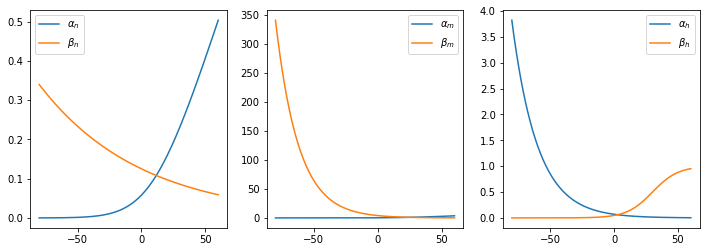

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(u, alpha_n(u), label=r"$\alpha_n$")
ax[0].plot(u, beta_n(u), label=r"$\beta_n$")
ax[0].legend()
ax[1].plot(u, alpha_m(u), label=r"$\alpha_m$")
ax[1].plot(u, beta_m(u), label=r"$\beta_m$")
ax[1].legend()
ax[2].plot(u, alpha_h(u), label=r"$\alpha_h$")
ax[2].plot(u, beta_h(u), label=r"$\beta_h$")
ax[2].legend()
plt.show()

In [18]:
def dydt(y, t, parameters):
    gK, gNa, gCl = parameters['gK'], parameters['gNa'], parameters['gCl']
    E_K, E_Na, E_Cl = parameters['E_K'], parameters['E_Na'], parameters['E_Cl']
    Cm = parameters['Cm']
    u, n, m, h = y
    I_app = parameters['I_app'](t)
    return [
        (I_app - (gK * n**4 * (u - E_K) + gNa * m**3 * h * (u - E_Na) + gCl * (u - E_Cl)) ) / Cm,
        alpha_n(u) * (1. - n) - beta_n(u) * n,
        alpha_m(u) * (1. - m) - beta_m(u) * m,
        alpha_h(u) * (1. - h) - beta_h(u) * h,
    ]

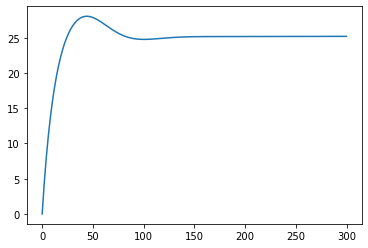

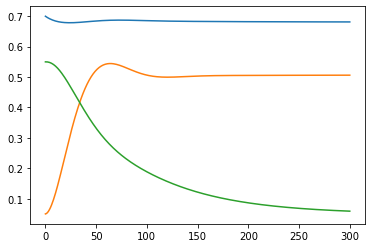

In [76]:
parameters = {
    "gNa" : 35.0e-2, # mS/cm^2
    "gK"  : 40.0e-2, # mS/cm^
    "gCl" : 0.3e-2, # mS/cm^  
    "E_Na": 55.0,  # mV
    "E_K" : -77.0, # mV
    "E_Cl": -65.0, # mV
    "Cm"  : 0.02,  # microFarad / cm^2
    "I_app": lambda t: 9 #t * (t < 5) + (5 - t) * (t > 5)
}

y0 = [
    0.0,
    0.7,
    0.05,
    0.55
]

t = np.linspace(0, 10, 301)

sol = odeint(dydt, y0, t, args=(parameters,), hmax=1e-4, full_output=0)
plt.plot(sol[:, 0])
plt.show()
plt.plot(sol[:, 1:])
plt.show()